In [2]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
# import nc_time_axis

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import linregress

import mtspec

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

import warnings
warnings.filterwarnings('ignore','SerializationWarning')

from defs import trim_axs, Nino34_timeseries, Nino_timeseries

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
## Figure settings

import matplotlib.pylab as pylab

figwidth1 = 8.3;
figwidth2 = 12;

r = figwidth2/figwidth1;

params1 = {'legend.fontsize':15,
         'axes.labelsize':16.5,
         'axes.titlesize':14.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

params2 = {'legend.fontsize':14.5,
         'axes.labelsize':15.5,
         'axes.titlesize':16.5,
         'xtick.labelsize':14.5,
         'ytick.labelsize':14.5}

cmap_temp = plt.get_cmap('cmo.thermal');
cmap_div  = plt.get_cmap('cmo.balance');
cmap_diff = plt.get_cmap('RdBu_r');

# pylab.rcParams.update(params)

## Load observations

In [4]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

# select last 100 years
ds = ds.sel(time=slice("1920", "2019"))

# -180 to 180 transform to 0 - 360
ds.coords['longitude'] = (ds.coords['longitude'] - 360) % 360
ds = ds.sortby(ds.longitude)
ds = ds.sortby(ds.latitude)

# slice equatorial pacific
minlat = -5;  maxlat = 5;  
minlon = 210; maxlon = 270; ## Nino3
n3 = ds.sst.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='latitude').mean(dim='longitude')
n3 = n3.groupby('time.month') - n3.groupby('time.month').mean(dim='time')

## linear detrending (to remove 'climate change' trends)
t = range(len(n3)); p = np.polyfit(t, n3, 1);
l = t*p[0] + p[1]; n3 = n3 - l;

minlon = 160; maxlon = 210; ## Nino4
n4 = ds.sst.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='latitude').mean(dim='longitude')
n4 = n4.groupby('time.month') - n4.groupby('time.month').mean(dim='time')

## linear detrending (to remove 'climate change' trends)
p = np.polyfit(t, n4, 1);
l = t*p[0] + p[1]; n4 = n4 - l;

## Nct Nwp
alpha = (2/5) * ((n3*n4)>0);
nCT_hadisst = n3 - alpha * n4; 
nWP_hadisst = n4 - alpha * n3;


## Load model list

In [5]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']


## Nino3 & Nino4 indices - CT / WP Nino flavours

Following the methods as proposed by Ren and Jin (2011): doi:10.1029/2010GL046031

Cold tongue (CT) and Warm pool (WP) El Nino types:\
$N_{CT} = N_3 - \alpha N_4$\
$N_{WP} = N_4 - \alpha N_3$

where\
$\alpha = 2/5$ if $N_3 N_4 > 0$\
$\alpha = 0$ otherwise

In [6]:
trend_type = "linear" # linear detrending of Nino34 series

for i in range(len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds1 = Nino_timeseries(model = modellist[i], run='E280', mode = 'Nino3', trend = trend_type)
    ds2 = Nino_timeseries(model = modellist[i], run='E280', mode = 'Nino4', trend = trend_type)
    
    if i==0: 
        nino3_e280   = np.zeros((len(ds1), len(modellist)))    
        nino3_eoi400 = np.zeros((len(ds1), len(modellist)))         
        nino4_e280   = np.zeros((len(ds2), len(modellist)))    
        nino4_eoi400 = np.zeros((len(ds2), len(modellist))) 
        
    nino3_e280[:,i]   = ds1
    nino3_eoi400[:,i] = Nino_timeseries(model = modellist[i], run='EOI400', mode = 'Nino3', trend = trend_type)    
    nino4_e280[:,i]   = ds2
    nino4_eoi400[:,i] = Nino_timeseries(model = modellist[i], run='EOI400', mode = 'Nino4', trend = trend_type)
    
    

model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


In [8]:
## Calcualte N_coldtongue and N_warmpool and the standard deviation of these time series

nCT_e280 = np.empty(nino3_e280.shape)
nWP_e280 = np.empty(nino3_e280.shape)
nCT_eoi400 = np.empty(nino3_e280.shape)
nWP_eoi400 = np.empty(nino3_e280.shape)

for i in range(len(modellist)):

    n3 = nino3_e280[:,i]; 
    n4 = nino4_e280[:,i];
    alpha = (2/5) * ((n3*n4)>0);
    nCT_e280[:,i] = n3 - alpha * n4; 
    nWP_e280[:,i] = n4 - alpha * n3;

    n3 = nino3_eoi400[:,i]; 
    n4 = nino4_eoi400[:,i];
    alpha = (2/5) * ((n3*n4)>0);
    nCT_eoi400[:,i] = n3 - alpha * n4; 
    nWP_eoi400[:,i] = n4 - alpha * n3;

std_nCT_e280 = np.std(nCT_e280, axis = 0)
std_nWP_e280 = np.std(nWP_e280, axis = 0)
std_nCT_eoi400 = np.std(nCT_eoi400, axis = 0)
std_nWP_eoi400 = np.std(nWP_eoi400, axis = 0)

# **Figure 6**

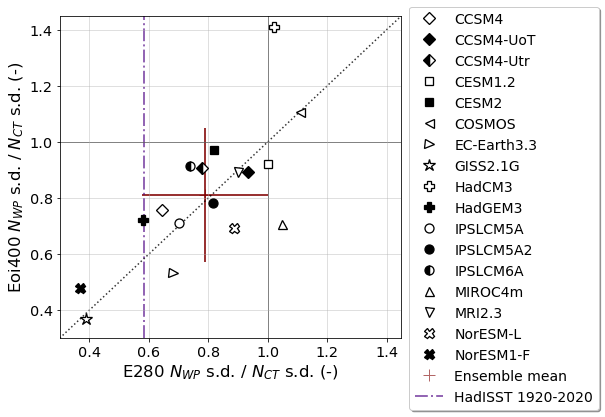

In [31]:

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

pylab.rcParams.update(params1)
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(figwidth1, 5.65), constrained_layout = True)

x = std_nWP_e280/std_nCT_e280; y = std_nWP_eoi400/std_nCT_eoi400;
lims = [0.3, 1.45]

for i in range(len(modellist)):
    ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
    markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
    
emcolor = 'maroon';
ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)  

ax.plot([np.std(nWP_hadisst)/np.std(nCT_hadisst), np.std(nWP_hadisst)/np.std(nCT_hadisst)], lims, color = 'indigo', linestyle='-.', linewidth=2, alpha=.6, zorder=-1, label = 'HadISST 1920-2020')

# grid
ax.grid(alpha=0.5);
ax.plot(lims, lims,'k:', alpha=0.8, zorder = -1);
ax.plot(lims, [1.0, 1.0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.plot([1.0, 1.0], lims, 'k-', alpha=0.6, zorder=-1, linewidth=1)
ax.set_xlim(lims); ax.set_ylim(lims)

ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1.05), shadow=True, ncol=1, fontsize=14)

ax.set_xlabel('E280 $N_{WP}$ s.d. / $N_{CT}$ s.d. (-)'); 
ax.set_ylabel('Eoi400 $N_{WP}$ s.d. / $N_{CT}$ s.d. (-)');


plt.savefig('figures/figure6.pdf', bbox_inches='tight')
